In [136]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
from __future__ import print_function, absolute_import
import matplotlib.pyplot as plt
import numpy as np

import pydrake
from pydrake.all import (
    AutoDiffXd, Expression, Variable,
    MathematicalProgram, SolverType, SolutionResult,
    DirectCollocationConstraint, AddDirectCollocationConstraint,
    PiecewisePolynomial,
    DiagramBuilder, SignalLogger, Simulator, VectorSystem,
)

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

from traj.dircol import (
    make_real_dircol_mp,
)

from nn_system.NNSystemHelper import (
    make_NN_constraint,
)

from nn_system.networks import *

In [114]:
##############################
#       SETTINGS
##############################
# kNetConstructor = FC
# kNetConstructor = MLPSMALL
kNetConstructor = MLP
kNumTimesteps = 21
prog, tree = make_real_dircol_mp(expmt="acrobot", seed=1776)

# Make vars for mathematical program to know about neural network
num_params = sum(tensor.nelement() for tensor in kNetConstructor().parameters())
num_inputs = 1
num_states = 4
print("total params: ", sum((num_inputs, num_states, num_params)))
T = prog.NewContinuousVariables(num_params, 'T')

# Apply this NN constraint to all timesteps!
for t in range(kNumTimesteps):
    # Only one output value, so let's have lb and ub of just size one!
    constraint = make_NN_constraint(kNetConstructor, num_inputs, num_states, num_params)
    lb         = -np.array([.1])
    ub         = np.array([.1])
    var_list   = np.hstack((prog.input(t), prog.state(t), T))
    prog.AddConstraint(constraint, lb, ub, var_list)
    pass


total params:  438


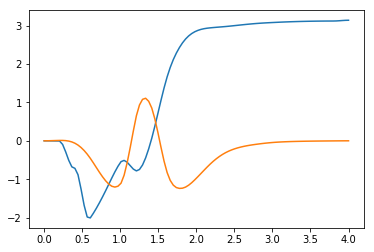

In [4]:
############################################################
# Run this cell to run the code!
############################################################

prog.SetSolverOption(SolverType.kSnopt, 'Print file', "/tmp/snopt.out")
ret = prog.Solve()

x_trajectory = prog.ReconstructStateTrajectory()
breaks = np.linspace(x_trajectory.start_time(),x_trajectory.end_time(),100)
x_knots = np.hstack([x_trajectory.value(t) for t in breaks])

plt.plot(breaks, x_knots[0,:], breaks, x_knots[1,:])

## Test make_NN_constraint

In [4]:
# kNetConstructor = FC
kNetConstructor = MLPSMALL
num_params = sum(tensor.nelement() for tensor in kNetConstructor().parameters())
num_inputs = 1
num_states = 4
total_params = sum((num_inputs, num_states, num_params))
print("total params: ", total_params)

constraint = make_NN_constraint(kNetConstructor, num_inputs, num_states, num_params)

total params:  134


In [ ]:
import copy
np.random.seed(1776)
# Make total_param number of AutoDiffXd's, with (seeded) random values.
# Set derivatives array to length total_param with only index i set for ith AutoDiff.
# values = np.random.randn(total_params)
values = np.ones(total_params)
def one_hot(i, n_params):
    ret = np.zeros(n_params)
    ret[i] = 1
    return ret

uxT = np.array([AutoDiffXd(values[i], one_hot(i, total_params)) for i in range(total_params)])
out = copy.deepcopy(constraint(uxT)[0])
out_value = out.value()
out_derivatives = out.derivatives()

# f     : function(np.array of AutoDiffXd's) -> array of size one of AutoDiffXd
# x     : np.array of AutoDiffXd at which to calculate finite_difference
# idx   : Index of AutoDiffXd in x to perturb
# delta : magnitude of perturbation of AutoDiffXd at index idx of x
def finite_difference(f, x, idx, delta):
    x_hi = copy.deepcopy(x)
    x_hi[idx] += delta
    x_lo = copy.deepcopy(x)
    x_lo[idx] -= delta
    return ( f(x_hi)[0].value() - f(x_lo)[0].value() ) / (2*delta)

for idx in range(total_params):    
    # Do finite difference calculation and compare against gradient
    grad = finite_difference(constraint, uxT, idx, 0.1)
    ref_grad = out_derivatives[idx]
    print(idx, grad, ref_grad)

## Trying out multiple trajectories with Russ's example code and Pendulum env

In [144]:
import math

from traj.dircol import (
    make_multiple_dircol_trajectories,
    make_real_dircol_mp,
)
from traj.vis import (
    add_multiple_trajectories_visualization_callback,
    add_visualization_callback,
    create_nn_policy_system,
    plot_multiple_dircol_trajectories,
    simulate_and_log_policy_system,
    visualize_trajectory,
)

num_trajectories = 1
num_samples      = 15
n_theta, n_theta_dot = (5, 3)
theta_bounds     = -math.pi, math.pi
theta_dot_bounds = -5, 5
def initial_conditions(ti):
    # Russ's
    return (.8 + math.pi - .4*ti, 0.0)
def initial_conditions2(ti):
    # Have ti index into a grid over some state space bounds
    theta_range     = np.linspace(theta_bounds[0], theta_bounds[1], n_theta)
    theta_dot_range = np.linspace(theta_dot_bounds[0], theta_dot_bounds[1], n_theta_dot)
    r = int(ti / n_theta)
    c = ti % n_theta
    return (theta_range[c], theta_dot_range[r])
def initial_conditions3(ti):
    # random state over some state-space bounds
    rand1, rand2 =  np.random.random(2)
    theta     =  (theta_bounds[1] - theta_bounds[0]) * rand1 + theta_bounds[0]
    theta_dot =  (theta_dot_bounds[1] - theta_dot_bounds[0]) * rand2 + theta_dot_bounds[0]
    return theta, theta_dot
    
prog, h, u, x = make_multiple_dircol_trajectories(
                    num_trajectories, 
                    num_samples)#,
#                     initial_conditions=initial_conditions2)

# kNetConstructor = lambda: FC(2)
kNetConstructor = lambda: FCBIG(2)
# kNetConstructor = lambda: MLPSMALL(2)
# kNetConstructor = lambda: MLP(2)
num_params = sum(tensor.nelement() for tensor in kNetConstructor().parameters())
num_inputs = 1
num_states = 2
total_params = sum((num_inputs, num_states, num_params))
T = prog.NewContinuousVariables(num_params, 'T')

# Add No/L1/L2 Regularization to model params T
# reg_type= "No"
reg_type= "L1"
# reg_type= "L2"
if reg_type == "No":
    pass
elif reg_type == "L1":
    def L1Cost(T):
        return sum([t**2 for t in T])
    prog.AddCost(L1Cost, T)
elif reg_type == "L2":
    prog.AddQuadraticCost(np.eye(len(T)), [0.]*len(T), T)

# VERY IMPORTANT!!!! - PRELOAD T WITH THE NET'S INITIALIZATION.
# DEFAULT ZERO INITIALIZATION WILL GIVE YOU ZERO GRADIENTS!!!!
params_loaded = 0
initial_guess = [AutoDiffXd]*num_params
for param in kNetConstructor().parameters():
    param_values = param.data.numpy().flatten()
    for i in range(param.data.nelement()):
        initial_guess[params_loaded + i] = param_values[i]
    params_loaded += param.data.nelement()
prog.SetInitialGuess(T, np.array(initial_guess))

for ti in range(num_trajectories):
    for i in range(num_samples):
        u_ti = u[ti][0,i]
        x_ti = x[ti][:,i]
        # Only one output value, so let's have lb and ub of just size one!
        constraint = make_NN_constraint(kNetConstructor, num_inputs, num_states, num_params)
        lb         = np.array([-.1])
        ub         = np.array([.1])
        var_list   = np.hstack((u_ti, x_ti, T))
        prog.AddConstraint(constraint, lb, ub, var_list)
#         prog.AddCost(lambda x: constraint(x)[0]**2, var_list)

In [145]:
# Introduce a scaling factor in (0, 1] that can be used to shrink the initial
# conditions regions used for policy rollouts, so we can check an area SMALLER
# than that which was used for dircol calculations!
scaling = 0.5
add_multiple_trajectories_visualization_callback(
    prog, h, u, x, T, 
    num_trajectories, num_samples, 
    kNetConstructor, 
    "pendulum")#,
#     initial_conditions=lambda ti: np.array(initial_conditions2(ti))*scaling )

1 2


13451346134713481349135013511352135313541355135613571358135913601361

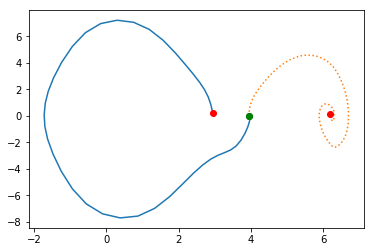

13621363136413651366136713681369137013711372137313741375137613771378

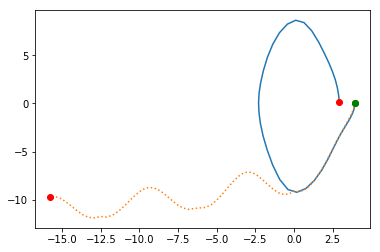

13791380138113821383138413851386138713881389139013911392139313941395

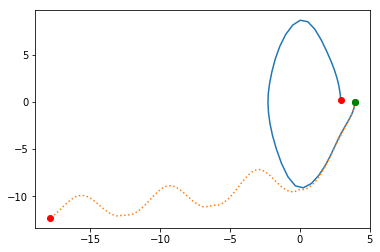

13961397139813991400140114021403140414051406140714081409141014111412

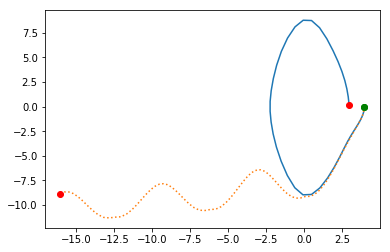

14131414141514161417141814191420142114221423142414251426142714281429

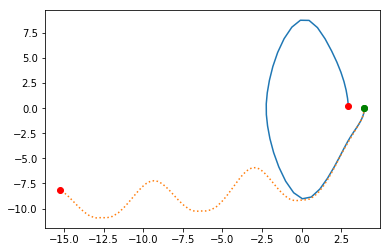

14301431143214331434143514361437143814391440144114421443144414451446

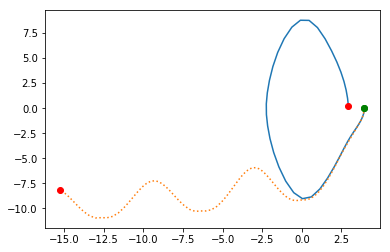

14471448144914501451145214531454145514561457145814591460146114621463

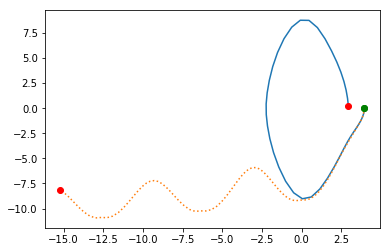

14641465146614671468146914701471147214731474147514761477147814791480

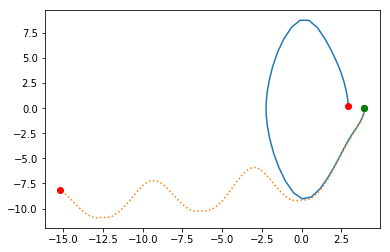

14811482148314841485148614871488148914901491149214931494149514961497

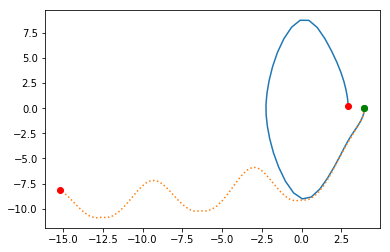

14981499150015011502150315041505150615071508150915101511151215131514

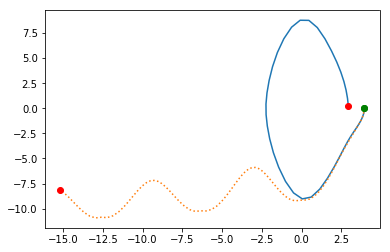

15151516151715181519152015211522152315241525152615271528152915301531

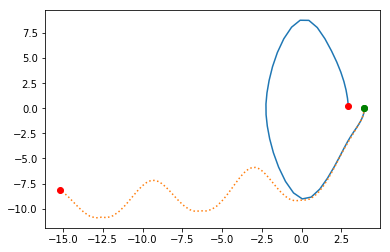

15321533153415351536153715381539154015411542154315441545154615471548

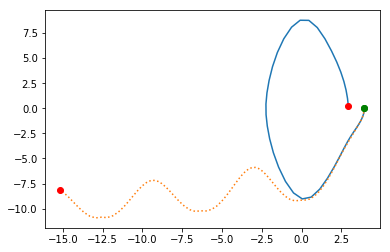

15491550155115521553155415551556155715581559156015611562156315641565

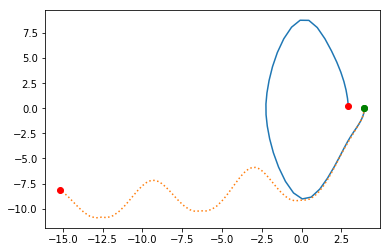

15661567156815691570157115721573157415751576157715781579158015811582

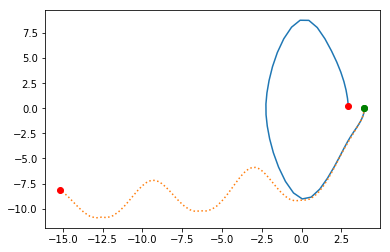

15831584158515861587158815891590159115921593159415951596159715981599

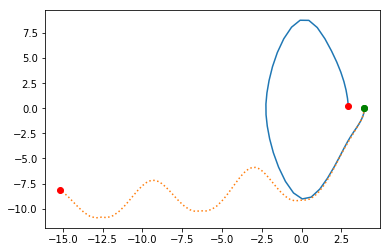

16001601160216031604160516061607160816091610161116121613161416151616

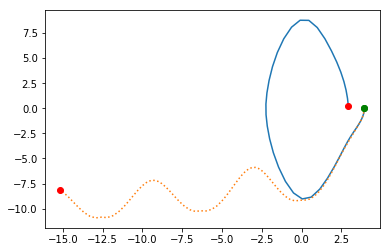

16171618161916201621162216231624162516261627162816291630163116321633

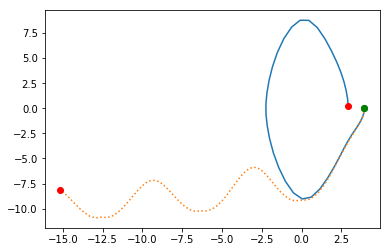

16341635163616371638163916401641164216431644164516461647164816491650

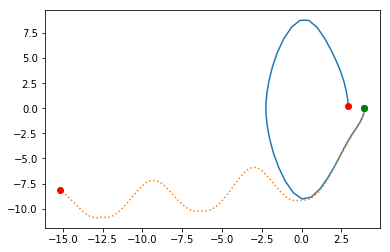

16511652165316541655165616571658165916601661166216631664166516661667

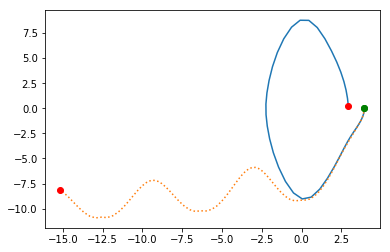

16681669167016711672167316741675167616771678167916801681168216831684

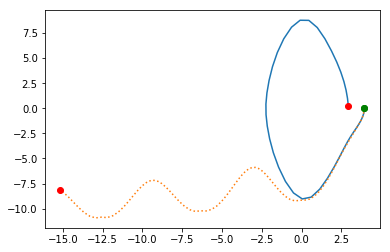

16851686168716881689169016911692169316941695169616971698169917001701

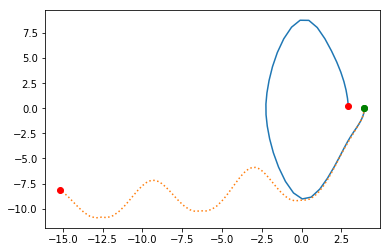

17021703170417051706170717081709171017111712171317141715171617171718

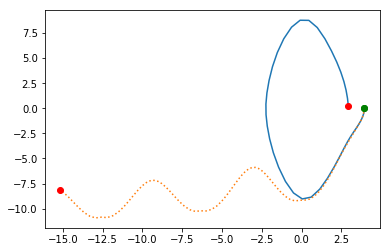

17191720172117221723172417251726172717281729173017311732173317341735

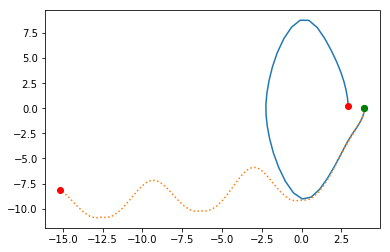

17361737173817391740174117421743174417451746174717481749175017511752

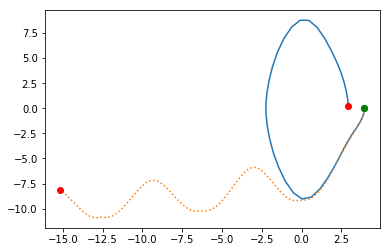

17531754175517561757175817591760176117621763176417651766176717681769

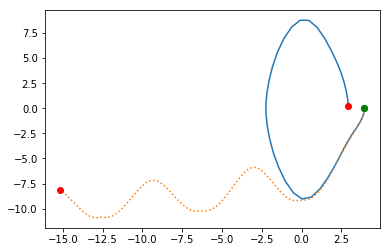

17701771177217731774177517761777177817791780178117821783178417851786

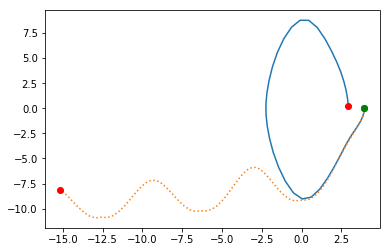

17871788178917901791179217931794179517961797179817991800180118021803

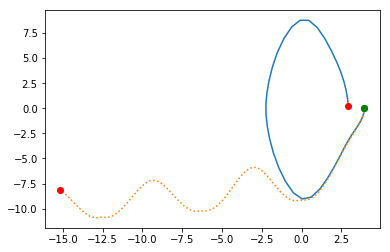

18041805180618071808180918101811181218131814181518161817181818191820

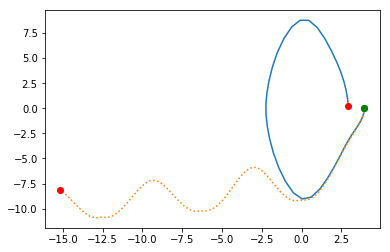

18211822182318241825182618271828182918301831183218331834183518361837

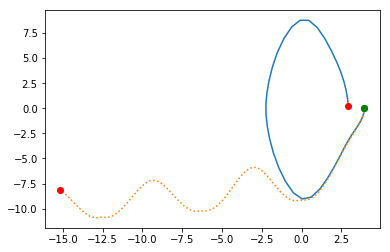

18381839184018411842184318441845184618471848184918501851185218531854

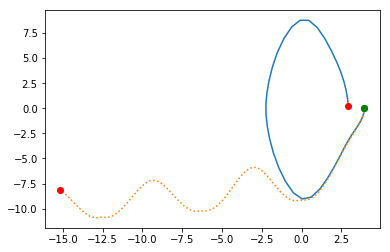

18551856185718581859186018611862186318641865186618671868186918701871

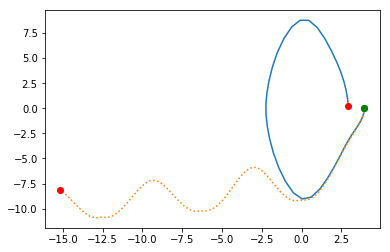

18721873187418751876187718781879188018811882188318841885188618871888

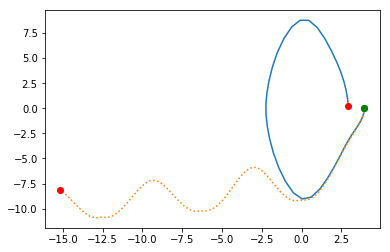

18891890189118921893189418951896189718981899190019011902190319041905

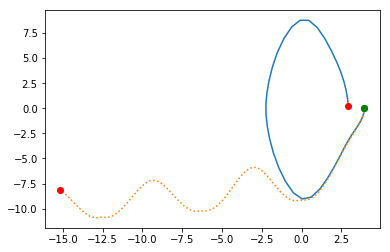

19061907190819091910191119121913191419151916191719181919192019211922

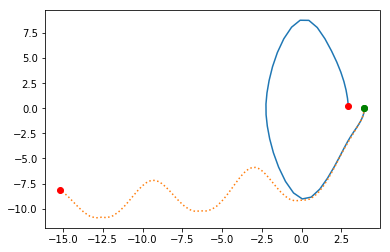

19231924192519261927192819291930193119321933193419351936193719381939

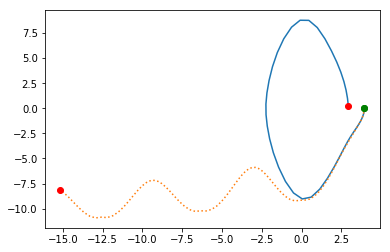

19401941194219431944194519461947194819491950195119521953195419551956

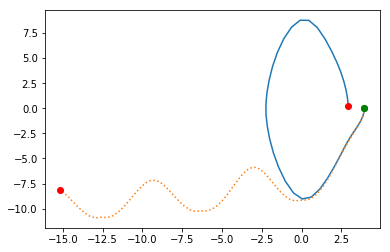

19571958195919601961196219631964196519661967196819691970197119721973

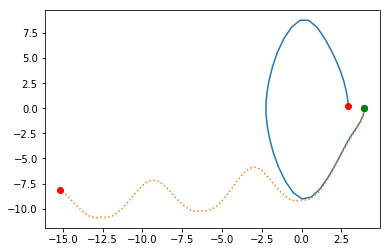

19741975197619771978197919801981198219831984198519861987198819891990

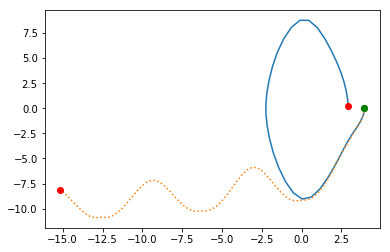

19911992199319941995199619971998199920002001200220032004200520062007

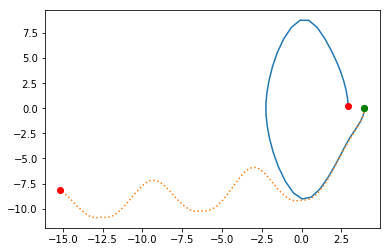

20082009201020112012201320142015201620172018201920202021202220232024

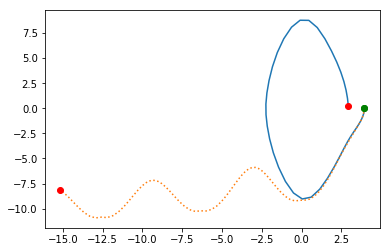

20252026202720282029203020312032203320342035203620372038203920402041

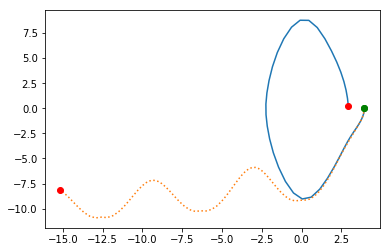

20422043204420452046204720482049205020512052205320542055205620572058

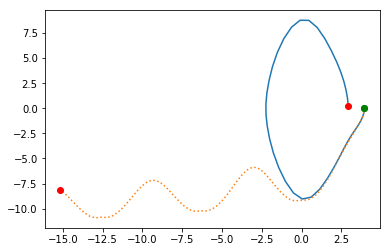

20592060206120622063206420652066206720682069207020712072207320742075

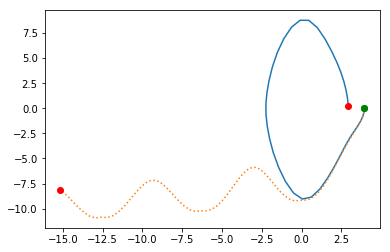

20762077207820792080208120822083208420852086208720882089209020912092

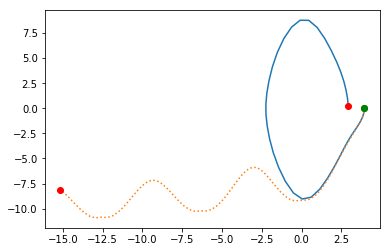

20932094209520962097209820992100210121022103210421052106210721082109

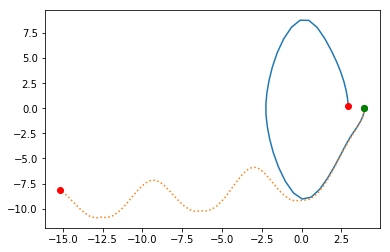

21102111211221132114211521162117211821192120212121222123212421252126

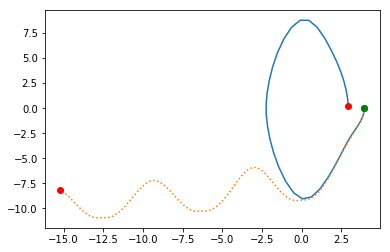

21272128212921302131213221332134213521362137213821392140214121422143

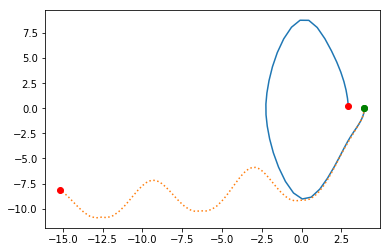

21442145214621472148214921502151215221532154215521562157215821592160

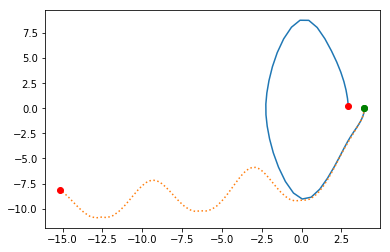

21612162216321642165216621672168216921702171217221732174217521762177

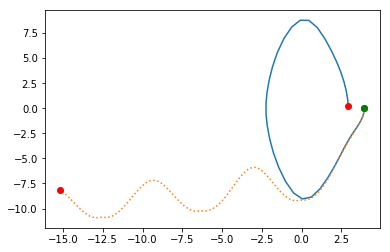

21782179218021812182218321842185218621872188218921902191219221932194

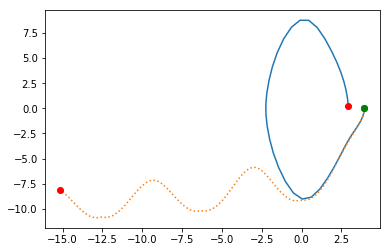

21952196219721982199220022012202220322042205220622072208220922102211

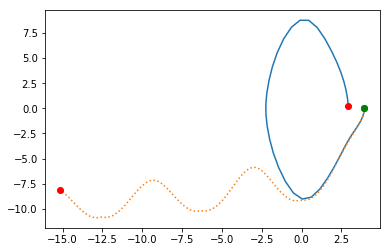

22122213221422152216221722182219222022212222222322242225222622272228

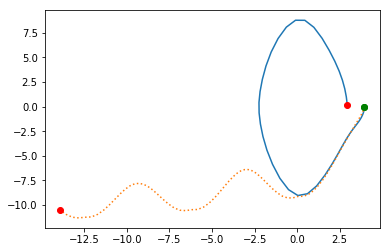

22292230223122322233223422352236223722382239224022412242224322442245

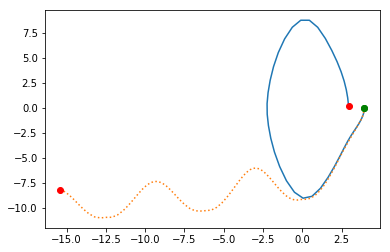

22462247224822492250225122522253225422552256225722582259226022612262

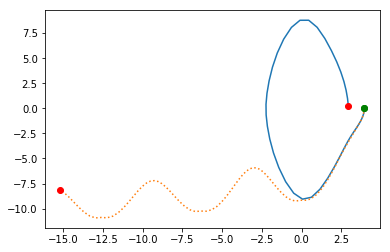

22632264226522662267226822692270227122722273227422752276227722782279

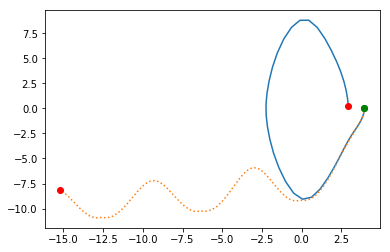

22802281228222832284228522862287228822892290229122922293229422952296

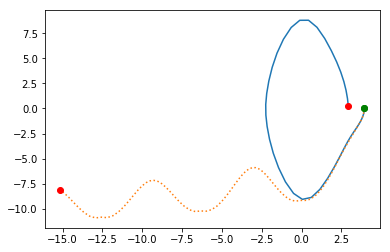

22972298229923002301230223032304230523062307230823092310231123122313

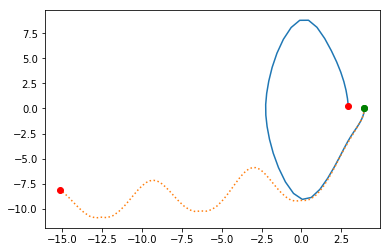

23142315231623172318231923202321232223232324232523262327232823292330

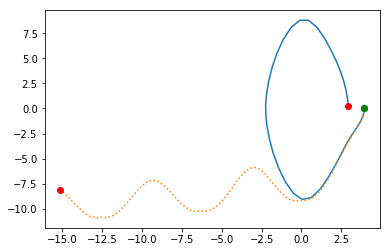

23312332233323342335233623372338233923402341234223432344234523462347

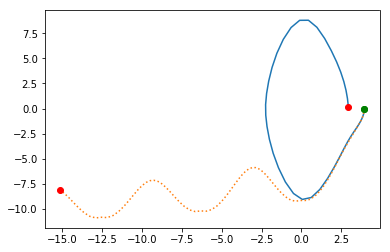

23482349235023512352235323542355235623572358235923602361236223632364

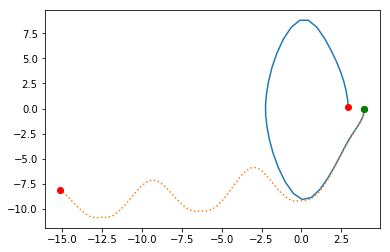

23652366236723682369237023712372237323742375237623772378237923802381

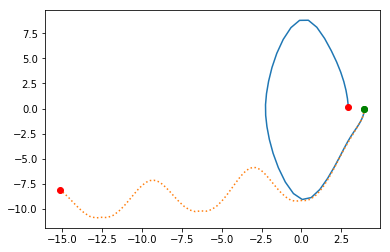

23822383238423852386238723882389239023912392239323942395239623972398

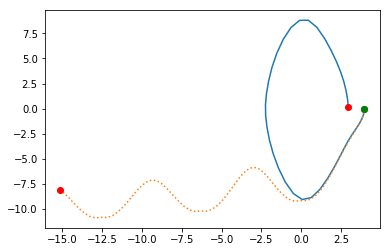

23992400240124022403240424052406240724082409241024112412241324142415

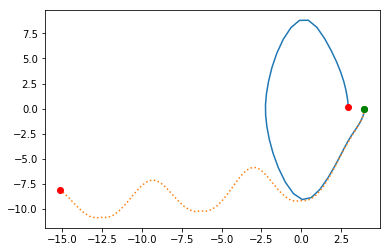

24162417241824192420242124222423242424252426242724282429243024312432

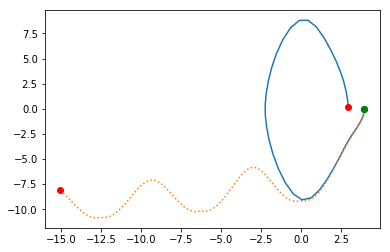

24332434243524362437243824392440244124422443244424452446244724482449

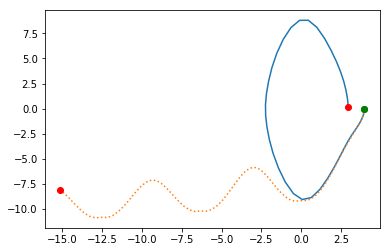

24502451245224532454245524562457245824592460246124622463246424652466

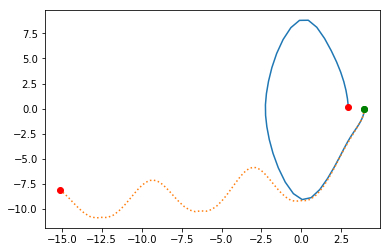

24672468246924702471247224732474247524762477247824792480248124822483

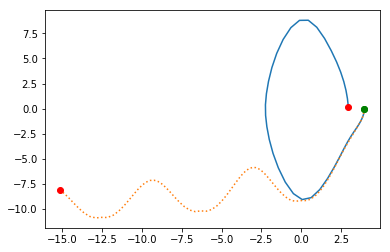

24842485248624872488248924902491249224932494249524962497249824992500

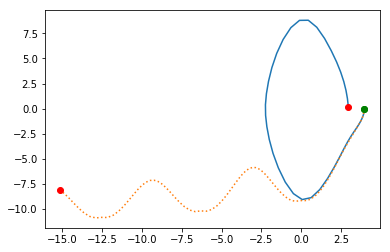

25012502250325042505250625072508250925102511251225132514251525162517

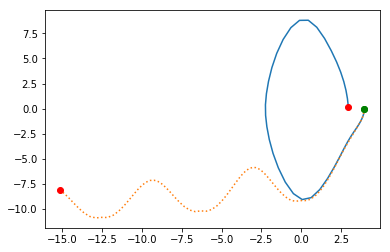

25182519252025212522252325242525252625272528252925302531253225332534

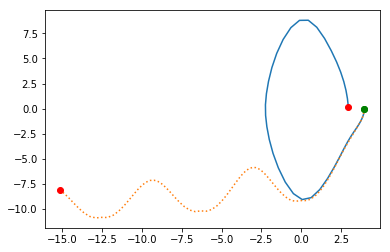

25352536253725382539254025412542254325442545254625472548254925502551

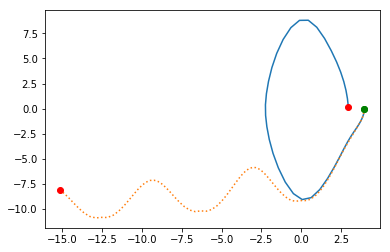

25522553255425552556255725582559256025612562256325642565256625672568

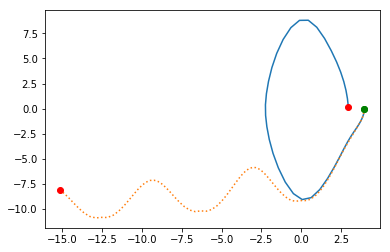

25692570257125722573257425752576257725782579258025812582258325842585

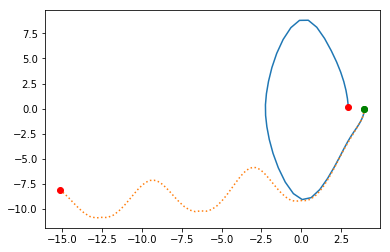

25862587258825892590259125922593259425952596259725982599260026012602

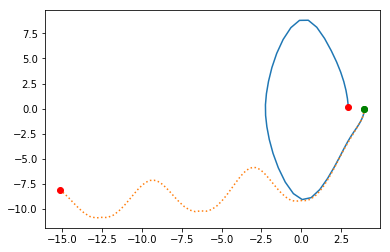

26032604260526062607260826092610261126122613261426152616261726182619

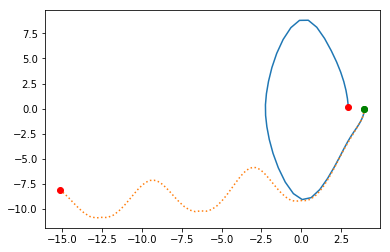

26202621262226232624262526262627262826292630263126322633263426352636

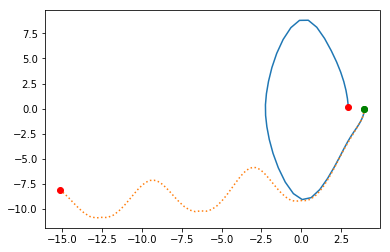

26372638263926402641264226432644264526462647264826492650265126522653

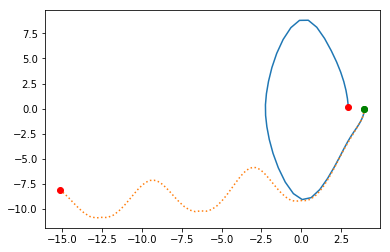

26542655265626572658265926602661266226632664266526662667266826692670

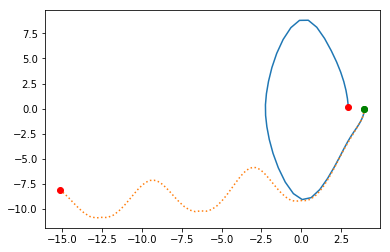

26712672267326742675267626772678267926802681268226832684268526862687

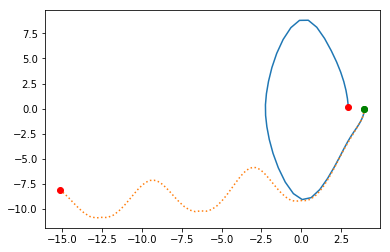

26882689269026912692269326942695269626972698269927002701270227032704

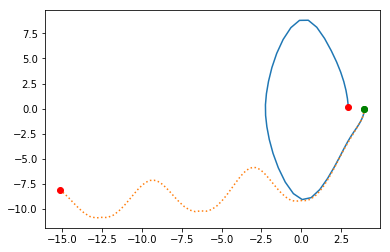

27052706270727082709271027112712271327142715271627172718271927202721

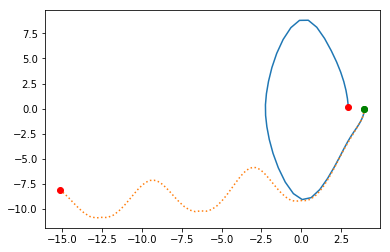

27222723272427252726272727282729273027312732273327342735273627372738

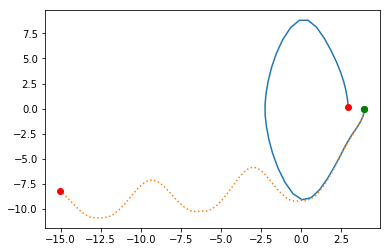

27392740274127422743274427452746274727482749275027512752275327542755

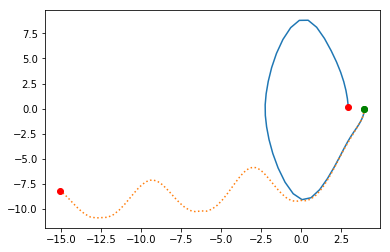

27562757275827592760276127622763276427652766276727682769277027712772

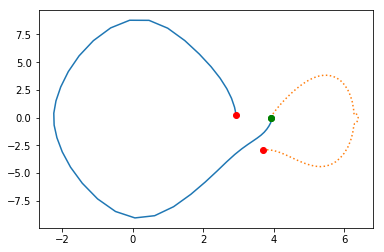

27732774277527762777277827792780278127822783278427852786278727882789

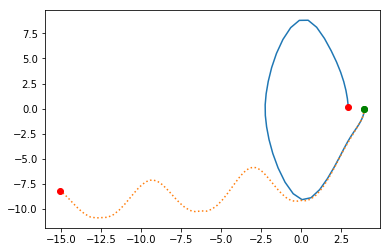

27902791279227932794279527962797279827992800280128022803280428052806

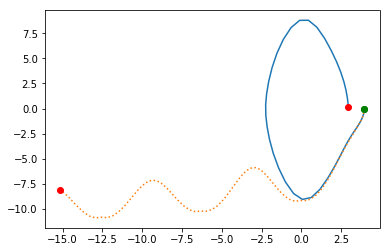

28072808280928102811281228132814281528162817281828192820282128222823

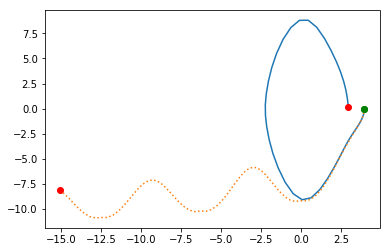

28242825282628272828282928302831283228332834283528362837283828392840

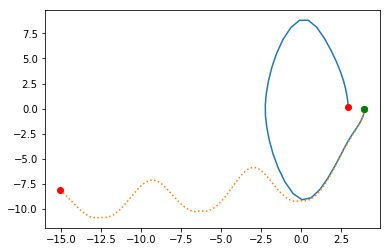

28412842284328442845284628472848284928502851285228532854285528562857

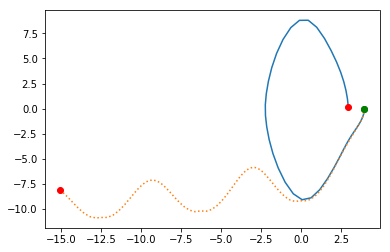

28582859286028612862286328642865286628672868286928702871287228732874

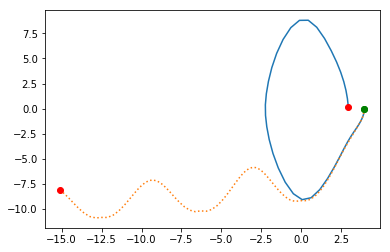

28752876287728782879288028812882288328842885288628872888288928902891

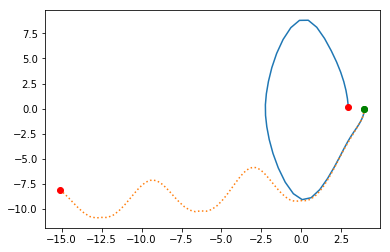

28922893289428952896289728982899290029012902290329042905290629072908

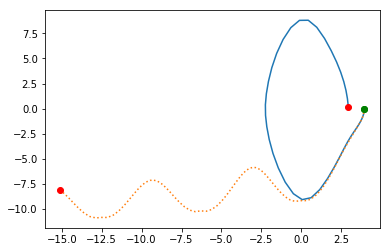

29092910291129122913291429152916291729182919292029212922292329242925

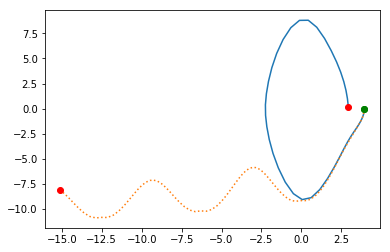

29262927292829292930293129322933293429352936293729382939294029412942

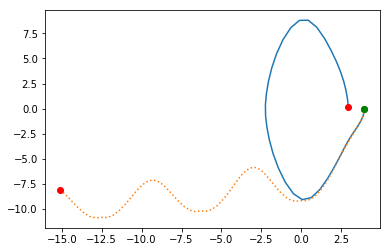

29432944294529462947294829492950295129522953295429552956295729582959

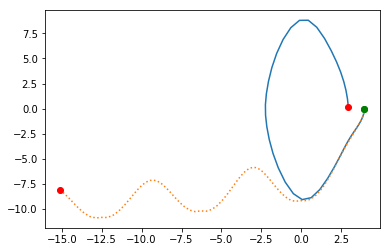

29602961296229632964296529662967296829692970297129722973297429752976

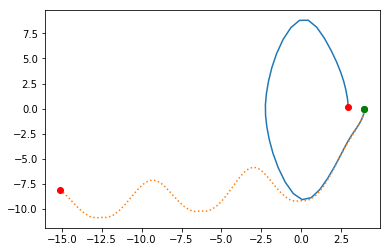

29772978297929802981298229832984298529862987298829892990299129922993

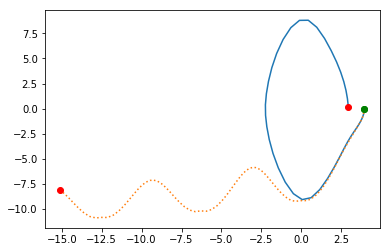

29942995299629972998299930003001300230033004300530063007300830093010

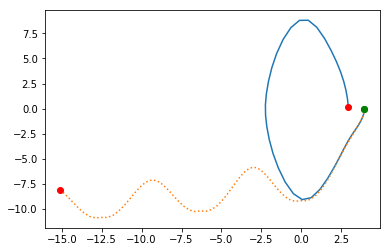

30113012301330143015301630173018301930203021302230233024302530263027

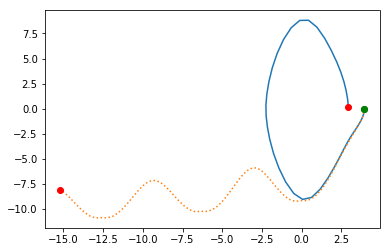

30283029303030313032303330343035303630373038303930403041304230433044

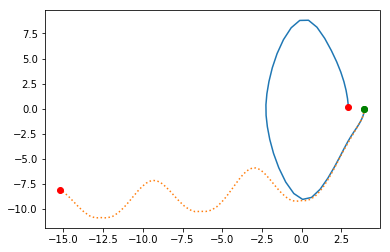

30453046304730483049305030513052305330543055305630573058305930603061

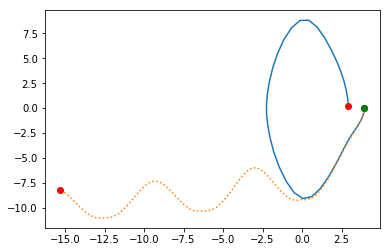

30623063306430653066306730683069307030713072307330743075307630773078

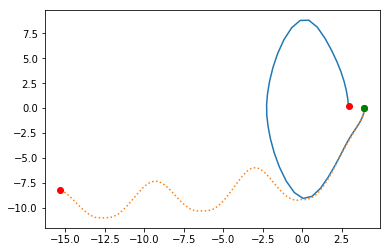

30793080308130823083308430853086308730883089309030913092309330943095

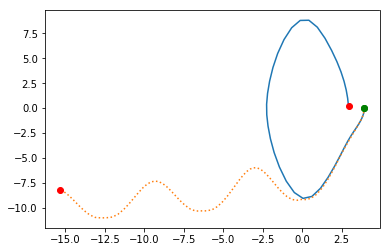

30963097309830993100310131023103310431053106310731083109311031113112

In [ ]:
result = prog.Solve()

In [ ]:
from nn_system.NNSystem import NNInferenceHelper_double
from nn_system.NNSystemHelper import create_nn

# print(list(kNetConstructor().parameters()))
nn = create_nn(kNetConstructor, prog.GetSolution(T))
# print(prog.GetSolution(T))
u_vals = prog.GetSolution(u[0])
x_vals = prog.GetSolution(x[0])
for i in range(num_samples):
    u_val = u_vals[0,i]
    x_val = x_vals[:,i]
    
    print( u_pi, " = " "NNInferenceHelper_double(nn, ", x_val, ")[0]")
    u_pi = NNInferenceHelper_double(nn, x_val)[0]
    print( u_val, " - ", u_pi, " = ", u_val - u_pi )

In [58]:
from traj.visualizer import PendulumVisualizer
from IPython.display import HTML

nn_policy = create_nn_policy_system(kNetConstructor, prog.GetSolution(T))
initial_conditions = prog.GetSolution(x[0])[:,0]
simulator, _, logger = simulate_and_log_policy_system(nn_policy, "pendulum", initial_conditions=initial_conditions)
h_sol = prog.GetSolution(h[0])[0]

simulator.StepTo(h_sol*num_samples)

# Visualize the result as a video.
vis = PendulumVisualizer()
ani = vis.animate(logger, repeat=True)

# Things added to get visualizations in an ipynb
plt.close(vis.fig)
HTML(ani.to_html5_video())

/home/rverkuil/integration/integration/local/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [306]:
print(result)

SolutionResult.kSolutionFound


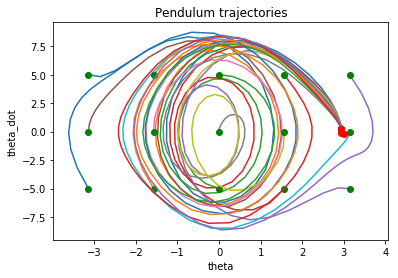

In [63]:
plot_multiple_dircol_trajectories(prog, h, u, x, num_trajectories, num_samples)

### Visualize the found trajectories

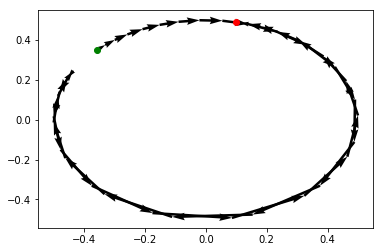

In [59]:
###### plt.figure()
# for ti in range(num_trajectories):
# for ti in [0]:

ti = 0

h_sol = prog.GetSolution(h[ti])[0]
breaks = [h_sol*i for i in range(num_samples)]
knots = prog.GetSolution(x[ti])
x_trajectory = PiecewisePolynomial.Cubic(breaks, knots, False)
t_samples = np.linspace(breaks[0], breaks[-1], 45)
x_samples = np.hstack([x_trajectory.value(t) for t in t_samples])

# Visualize with a static arrows plot.
visualize_trajectory(t_samples, x_samples, expmt="pendulum", create_figure=False)

# Visualize the result as a video.
vis2 = PendulumVisualizer()
ani2 = vis2.animate(x_trajectory, repeat=True)
plt.close(vis2.fig)
HTML(ani2.to_html5_video())

In [278]:
x=AutoDiffXd(1., [.1, .2])
x=AutoDiffXd(2., x.derivatives())
x

<AutoDiffXd 2.0 nderiv=2>